In [1]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker


from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange
from skimage.filters import gaussian
from scipy.ndimage import uniform_filter1d
from numpy.polynomial import Polynomial
from sklearn.metrics import r2_score

In [2]:
exp_sum = pd.read_excel('../Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
positions = pd.read_excel('../Positions.xlsx')

### Colonies per pad

In [3]:
## Here I used all the positions in order to count all the colonies per pad, not just the "very good" colonies
positions.columns

Index(['Date', 'Machine', 'Position', 'Strain', 'DNA', 'Chemical', 'Pad',
       'Dilution', 't_incub', 't_im', 'exp length', 'Quality', 'colonies',
       'center_colony', 'radius_mask', 'radj_mask', 'incub_time', 'um_px',
       'vel_start', 'vel_end', 'vel_fit_start', 'vel_fit_end',
       'time_wave_start', 'time_wave_arrival', 'degree', 'Delta used', 'Wave?',
       'Arrives?', 'Can measure?', 'Why not?', 'General Obs'],
      dtype='object')

In [4]:
# Group the data by 'Date', 'Machine', 'Dilution', and 'Pad', and sum the colonies
grouped_df = positions.groupby(['Date', 'Machine', 'Dilution', 'Pad'])['colonies'].sum().reset_index()

# Group by 'Dilution' and calculate the average number of colonies per pad, standard deviation, and total number of colonies
plot_data_colonies = grouped_df.groupby('Dilution').agg(
    mean=('colonies', 'mean'),
    std=('colonies', 'std'),
    sum=('colonies', 'sum')
).reset_index()

plot_data_colonies

,Dilution,mean,std,sum
0,10^(-5),14.480000,11.173331,362.0
1,10^(-6),5.583333,9.709024,67.0


In [5]:
grouped_df

,Date,Machine,Dilution,Pad,colonies
0,2023-11-15,Ti scope,10^(-5),1,19.0
1,2023-11-15,Ti scope,10^(-5),2,23.0
2,2023-11-15,Tweez scope,10^(-6),1,3.0
3,2023-11-15,Tweez scope,10^(-6),2,1.0
4,2023-11-17,Ti scope,10^(-5),1,6.0
5,2023-11-17,Tweez scope,10^(-6),1,3.0
6,2023-11-17,Tweez scope,10^(-6),2,1.0
7,2023-11-28,Ti scope,10^(-6),1,5.0
8,2023-11-28,Ti scope,10^(-6),2,2.0
9,2023-11-28,Tweez scope,10^(-5),1,14.0


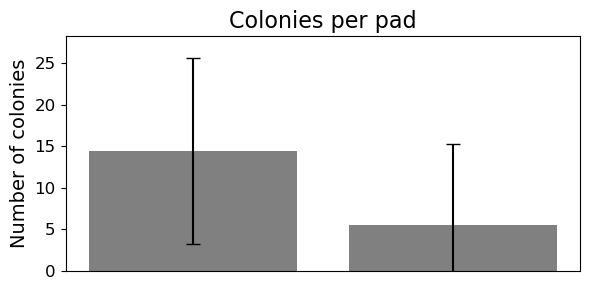

In [6]:
# Create a figure and axis
#fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(6, 3))

# Create a colormap
area_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data_colonies)))

# Calculate the maximum y-axis limit
max_tm = plot_data_colonies['mean'] + plot_data_colonies['std']
global_max = max_tm.max()

# Plot the data
for pos, row in plot_data_colonies.iterrows():
    ax.bar(pos, row['mean'], yerr=row['std'], capsize=5, color='gray', label=row['Dilution'])
    # Annotate the total number of colonies inside the bar
    #ax.text(pos, row['mean']/2, f'{int(row["sum"])}', ha='center', va='center', color='white', fontsize=14, fontweight='bold')

# Set the title and labels
ax.set_title('Colonies per pad', fontsize=16)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Number of colonies', fontsize=14)
ax.set_xticks([])
ax.set_xticklabels([], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
#ax.legend(title="Dilution", title_fontsize=14, fontsize=12)

# Adjust layout for better fit
plt.tight_layout()
plt.savefig('Colonies_per_pad.png', dpi=300)
# Show the plot
plt.show()

In [10]:
## Sumary table
plot_data_colonies

,Dilution,mean,std,sum
0,10^(-5),14.480000,11.173331,362.0
1,10^(-6),5.583333,9.709024,67.0


### Area per colony

In [11]:
## Here I just used the "very good" colonies, since I just computed the area for those.
df = pd.read_excel('../data_processed.xlsx')

In [12]:
plot_data = df.groupby('Dilution')['area_max_um'].agg(
    mean=('mean'),       # Calculate average
    std=('std'),        # Calculate standard deviation
    sum=('size')                  # Calculate count
).reset_index()
plot_data

,Dilution,mean,std,sum
0,10^(-5),238178.155362,119678.222948,130
1,10^(-6),560019.458100,252363.390831,30


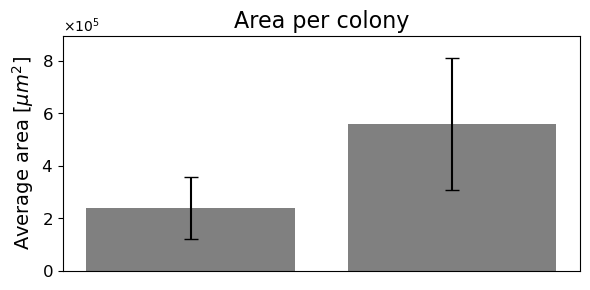

In [13]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 3))

# Calculate the maximum y-axis limit
max_tm = plot_data['mean'] + plot_data['std']
global_max = max_tm.max()

# Plot the data
for pos, row in plot_data.iterrows():
    ax.bar(pos, row['mean'], yerr=row['std'], capsize=5, color='gray', label=row['Dilution'])

# Set the title and labels
ax.set_title('Area per colony', fontsize=16)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Average area [$\mu m^2$]', fontsize=14)

# Use ScalarFormatter to apply scientific notation
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# Set consistent y-axis limits
ax.set_ylim(0, global_max * 1.1)

# Remove x-axis labels
ax.set_xticks([])
ax.set_xticklabels([])
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Adjust layout for better fit
plt.tight_layout()
plt.savefig('area_per_colony.png', dpi=300)

# Show the plot
plt.show()

### Area per pad

In [14]:
grouped_df = df.groupby(['Date', 'Machine', 'Dilution', 'Pad'])['area_max_um'].sum().reset_index()
plot_area_pad = grouped_df.groupby('Dilution').agg(
    mean=('area_max_um', 'mean'),    # Calculate the average area per pad
    std=('area_max_um', 'std'),      # Calculate the standard deviation of the area
).reset_index()
plot_area_pad

,Dilution,mean,std
0,10^(-5),1.407416e+06,9.795501e+05
1,10^(-6),1.527326e+06,1.346664e+06


In [15]:
counts = [130, 30]

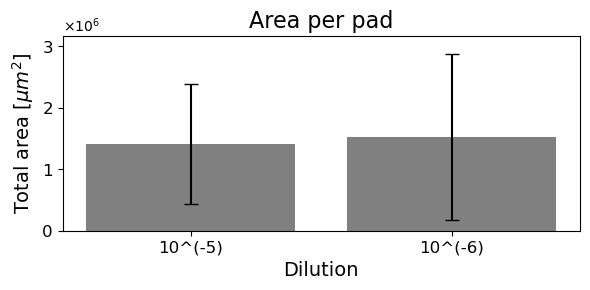

In [16]:
# Create a figure and axis
#fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(6, 3))

# Calculate the maximum y-axis limit
max_tm = plot_area_pad['mean'] + plot_area_pad['std']
global_max = max_tm.max()

# Plot the data
for pos, row in plot_area_pad.iterrows():
    ax.bar(pos, row['mean'], yerr=row['std'], capsize=5, color='gray', label=row['Dilution'])
    # Annotate the total number of colonies inside the bar
    #ax.text(pos, row['mean']/2, f'{counts[pos]}', ha='center', va='center', color='white', fontsize=14,fontweight='bold')

# Set the title and labels
ax.set_title('Area per pad', fontsize=16)
ax.set_xlabel('Dilution', fontsize=14)
ax.set_ylabel('Total area [$\mu m^2$]', fontsize=14)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.set_xticks([0,1])
ax.set_xticklabels(['10^(-5)','10^(-6)'], fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
#ax.legend(title="Dilution", title_fontsize=14, fontsize=12 )

# Adjust layout for better fit
plt.tight_layout()
plt.savefig('area_per_pad.png', dpi=300)

# Show the plot
plt.show()

#### Survival rate

In [18]:
5.6/2.38 /10

0.23529411764705882